In [ ]:
import gymnasium as gym
import gym_anytrading
import pandas as pd


In [15]:
df = pd.read_csv("../Raw/STOCKS_GOOGL.csv")

In [10]:
def process_df(df, window_size, frame_bound, price_column="Close"):
    start = frame_bound[0] - window_size
    end = frame_bound[1]

    # Select price series for reward computation
    prices = df[price_column].to_numpy()[start:end]

    # Use every column as a signal feature
    signal_features = df.to_numpy()[start:end]

    return prices, signal_features


In [24]:
class FlexibleTradingEnv(StocksEnv):
    def __init__(self, df, prices, signal_features, window_size, frame_bound, fee=0.001):
        self._prices = prices
        self._signal_features = signal_features
        self.fee = fee
        super().__init__(df=df, window_size=window_size, frame_bound=frame_bound)

    def _process_data(self):
        return self._prices, self._signal_features

    def _calculate_reward(self, action):
        # PPO-ready reward: dense + long/short + transaction cost
        price_now = self.prices[self._current_tick]
        price_prev = self.prices[self._current_tick - 1]
        price_diff = price_now - price_prev

        position_factor = 1 if self._position == Positions.Long else -1
        step_reward = position_factor * price_diff

        trade = (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        )
        if trade:
            step_reward -= self.fee * price_now

        return step_reward

    def _update_profit(self, action):
        price_now = self.prices[self._current_tick]
        price_prev = self.prices[self._current_tick - 1]

        if self._position == Positions.Long:
            factor = price_now / price_prev
        else:
            factor = price_prev / price_now

        trade = (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        )
        if trade:
            factor *= (1 - self.fee)

        self._total_profit *= factor


In [16]:
window_size = 30
frame_bound = (30, len(df))


prices, signal_features = process_df(df, window_size, frame_bound)


In [17]:
env = FlexibleTradingEnv(
    prices=prices,
    signal_features=signal_features,
    df=df,
    window_size=window_size,
    frame_bound=frame_bound
)

In [18]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

print()
print("custom_env information:")
print("> shape:", custom_env.unwrapped.shape)
print("> df.shape:", custom_env.unwrapped.df.shape)
print("> prices.shape:", custom_env.unwrapped.prices.shape)
print("> signal_features.shape:", custom_env.unwrapped.signal_features.shape)
print("> max_possible_profit:", custom_env.unwrapped.max_possible_profit())

env information:
> shape: (30, 7)
> df.shape: (2335, 7)
> prices.shape: (2335,)
> signal_features.shape: (2335, 7)
> max_possible_profit: 324533.23901761015

custom_env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 5.1919723


In [19]:
obs = env.reset()

done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

print(info)

{'total_reward': np.float64(284.54991500000006), 'total_profit': np.float64(0.00022244981180661105), 'position': <Positions.Short: 0>}


In [23]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

# -----------------------------------------------------------
# 1. IMPORT YOUR CUSTOM ENV
# -----------------------------------------------------------
# try:
#     from Project.env import PharmaTradingEnv  # adjust path as needed
#     print("✓ Imported PharmaTradingEnv successfully")
# except Exception as e:
#     print("✗ Error importing environment:", e)
#     raise


# -----------------------------------------------------------
# 2. BUILD A SIMPLE TEST INSTANCE
# -----------------------------------------------------------
def make_test_env():
    import pandas as pd

    # Simple dummy dataframe for testing
    df = pd.DataFrame({
        "Open": np.random.rand(200) * 100,
        "High": np.random.rand(200) * 100,
        "Low": np.random.rand(200) * 100,
        "Close": np.random.rand(200) * 100,
        "volume": np.random.rand(200),
        "pred": np.random.randn(200),
        "sentiment": np.random.randn(200),
    })

    window_size = 10
    frame_bound = (window_size, len(df))

    # Minimal process to match your real workflow
    prices = df["Close"].to_numpy().astype(np.float32)
    signal_features = df.to_numpy().astype(np.float32)


    env = FlexibleTradingEnv(
        df=df,
        prices=prices,
        signal_features=signal_features,
        window_size=window_size,
        frame_bound=frame_bound
    )

    return env


# -----------------------------------------------------------
# 3. BASIC ENV TESTS
# -----------------------------------------------------------
def test_env_basic(env):
    print("\n--- BASIC ENVIRONMENT TESTS ---")

    # Test reset
    try:
        obs, info = env.reset()
        print("✓ reset() works")
    except Exception as e:
        print("✗ reset() failed:", e)
        raise

    # Test observation shape & dtype
    if not isinstance(obs, np.ndarray):
        print("✗ Observation is not a numpy array")
    else:
        print("✓ Observation is numpy array")

    if obs.dtype != np.float32:
        print(f"✗ Observation dtype is {obs.dtype}, expected float32")
    else:
        print("✓ Observation dtype is float32")

    print("Observation shape:", obs.shape)


# -----------------------------------------------------------
# 4. STEP LOOP TEST
# -----------------------------------------------------------
def test_step_loop(env):
    print("\n--- STEP() LOOP TEST ---")

    obs, info = env.reset()
    done = False
    step_count = 0

    try:
        while not done and step_count < 20:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step_count += 1

        print("✓ step() loop works")
        print("Last reward:", reward)
        print("terminated:", terminated, "truncated:", truncated)
    except Exception as e:
        print("✗ step() loop failed:", e)
        raise


# -----------------------------------------------------------
# 5. ACTION SPACE TEST
# -----------------------------------------------------------
def test_action_space(env):
    print("\n--- ACTION SPACE TEST ---")
    try:
        action = env.action_space.sample()
        print("✓ action_space.sample() works:", action)
    except Exception as e:
        print("✗ action_space failed:", e)
        raise


# -----------------------------------------------------------
# 6. PPO COMPATIBILITY TEST
# -----------------------------------------------------------
def test_ppo(env):
    print("\n--- PPO COMPATIBILITY TEST ---")
    try:
        vec_env = DummyVecEnv([lambda: env])
        model = PPO("MlpPolicy", vec_env, verbose=0)
        model.learn(total_timesteps=1)
        print("✓ PPO can run a single timestep")
    except Exception as e:
        print("✗ PPO training failed:", e)
        raise


# -----------------------------------------------------------
# RUN ALL TESTS
# -----------------------------------------------------------
if __name__ == "__main__":

    env = make_test_env()

    test_env_basic(env)
    test_step_loop(env)
    test_action_space(env)
    test_ppo(env)

    print("\nALL TESTS COMPLETED.")



--- BASIC ENVIRONMENT TESTS ---
✓ reset() works
✓ Observation is numpy array
✓ Observation dtype is float32
Observation shape: (10, 7)

--- STEP() LOOP TEST ---
✓ step() loop works
Last reward: 0
terminated: False truncated: False

--- ACTION SPACE TEST ---
✓ action_space.sample() works: 0

--- PPO COMPATIBILITY TEST ---
✓ PPO can run a single timestep

ALL TESTS COMPLETED.


info: {'total_reward': np.float32(27.89616), 'total_profit': np.float32(0.9898121), 'position': <Positions.Long: 1>}


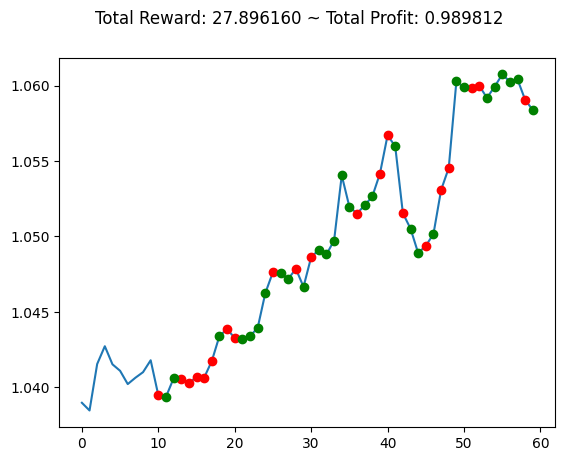

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL


env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()